<a href="https://colab.research.google.com/github/abia200304/Distinct-Vehicle-Flow-Prediction-/blob/main/MLP_PEMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
   creating: my_pems_data/
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-202

In [ ]:
from glob import glob
import pandas as pd
import numpy as np

file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [ ]:
combined_df = pd.concat(all_data, ignore_index=True)
print(combined_df.shape)

(22824, 2)


In [ ]:
def process_traffic_data(df):

    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features
    processed_df['time_index'] = range(len(processed_df))

    return processed_df


In [ ]:
processed_df = process_traffic_data(combined_df)


In [ ]:
display(processed_df)
print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,22.0,0.0,22.0,0
1,27.0,0.0,27.0,1
2,29.0,0.0,29.0,2
3,18.0,0.0,18.0,3
4,14.0,0.0,14.0,4
...,...,...,...,...
22819,32.0,0.0,32.0,22819
22820,24.0,0.0,24.0,22820
22821,29.0,0.0,29.0,22821
22822,26.0,0.0,26.0,22822


(22824, 4)


In [ ]:

processed_df.columns

Index(['total_flow', 'truck_flow', 'non_truck_flow', 'time_index'], dtype='object')

In [ ]:
column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

In [ ]:
coloumn_1_data=np.array(column_1_data)
coloumn_2_data=np.array(column_2_data)

In [ ]:
column1_data=coloumn_1_data.reshape(-1,1)
column2_data =coloumn_2_data.reshape(-1,1)

In [ ]:
data = np.concatenate([ column1_data,column2_data],axis =1)
print(data.shape)

(22824, 2)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler((0,1))
scaled_data=scalar.fit_transform(data)

In [ ]:
scaled_data.shape

(22824, 2)

In [ ]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)
time_step = 15
X, Y= create_dataset(scaled_data, time_step)
print(X.shape)
print(Y.shape)

(22809, 15, 2)
(22809, 2)


In [ ]:
X_train=X[:int(0.8*len(X))]
y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
X_test = X[int(0.8*len(X)):]
y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18247, 15, 2)
(18247, 2)
(4562, 15, 2)
(4562, 2)


In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

model = Sequential()
model.add(Flatten(input_shape=(15, 2)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))

model.add(Dense(2, activation='linear',kernel_regularizer=regularizers.l2(0.1)))




model.compile(optimizer='adam', loss='mse')

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,878 (202.65 KB)

 Trainable params: 51,878 (202.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history=model.fit(X_train,y_train,epochs=50,validation_split=0.15,verbose=1)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2141 - val_loss: 0.0623
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0424 - val_loss: 0.0100
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 11/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 12/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
model.save('mlp_model.keras')

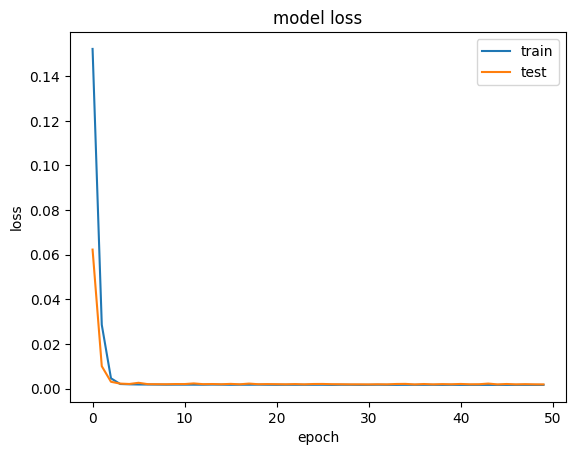

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')


In [ ]:

y_pred=model.predict(X_test)
test_predict=model.predict(X_test)
print(test_predict.shape)
predictions_original_scale = scalar.inverse_transform(test_predict)
y_test_original_scale = scalar.inverse_transform(y_test)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
(4562, 2)


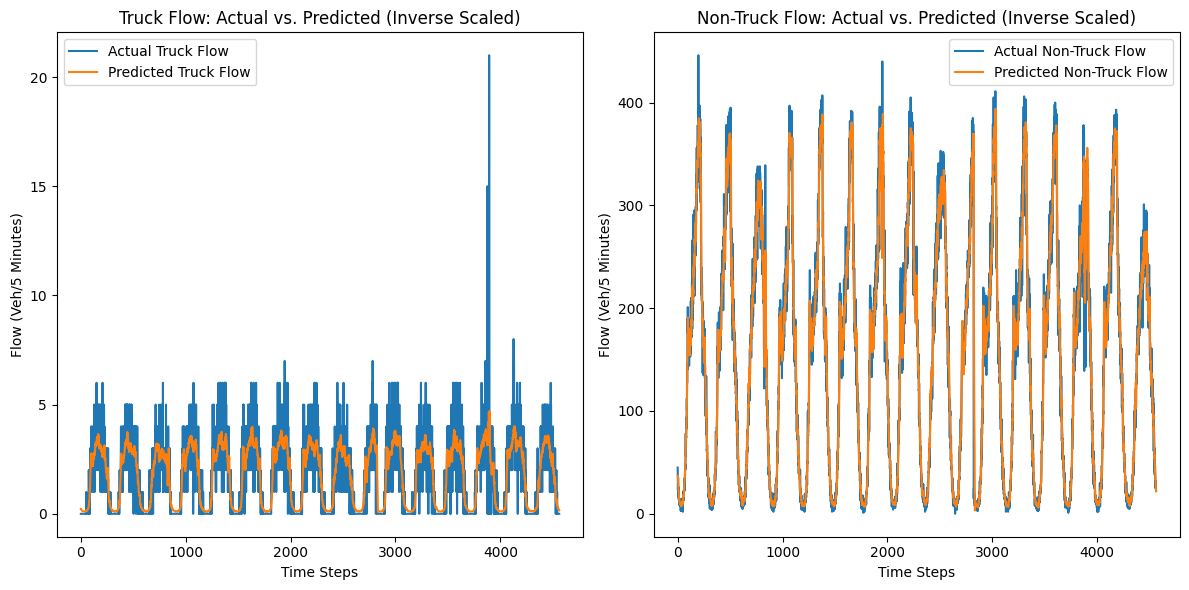

--- Metrics for Truck Flow (Original Scale) ---
RMSE: 0.9712
MAE: 0.6418
MAPE (masked): 37.15%

--- Metrics for Non-Truck Flow (Original Scale) ---
RMSE: 19.9306
MAE: 12.9937
MAPE (masked): 17.82%


In [ ]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))

# #  Truck Flow
# plt.subplot(1, 2, 1)
# plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
# plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
# plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# # Non-Truck Flow
# plt.subplot(1, 2, 2)
# plt.plot(y_test_original_scale[:, 1] , label='Actual Non-Truck Flow')
# plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
# plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# plt.tight_layout()
# plt.show()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 1], label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Truck Flow ---
actual_truck_flow = y_test_original_scale[:, 0]
predicted_truck_flow = predictions_original_scale[:, 0]

rmse_truck = np.sqrt(mean_squared_error(actual_truck_flow, predicted_truck_flow))
mae_truck = mean_absolute_error(actual_truck_flow, predicted_truck_flow)

# Masked MAPE
mask_truck = actual_truck_flow != 0
mape_truck = np.mean(
    np.abs((actual_truck_flow[mask_truck] - predicted_truck_flow[mask_truck]) / actual_truck_flow[mask_truck])
) * 100

print(f"--- Metrics for Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_truck:.4f}")
print(f"MAE: {mae_truck:.4f}")
print(f"MAPE (masked): {mape_truck:.2f}%")

# --- Non-Truck Flow ---
actual_non_truck_flow = y_test_original_scale[:, 1]
predicted_non_truck_flow = predictions_original_scale[:, 1]

rmse_non_truck = np.sqrt(mean_squared_error(actual_non_truck_flow, predicted_non_truck_flow))
mae_non_truck = mean_absolute_error(actual_non_truck_flow, predicted_non_truck_flow)

# Masked MAPE
mask_non_truck = actual_non_truck_flow != 0
mape_non_truck = np.mean(
    np.abs((actual_non_truck_flow[mask_non_truck] - predicted_non_truck_flow[mask_non_truck]) / actual_non_truck_flow[mask_non_truck])
) * 100

print(f"\n--- Metrics for Non-Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_non_truck:.4f}")
print(f"MAE: {mae_non_truck:.4f}")
print(f"MAPE (masked): {mape_non_truck:.2f}%")


In [ ]:
import tensorflow as tf

# === Load the saved MLP model ===
mlp_model = tf.keras.models.load_model('mlp_model.keras', compile=False)

# === Set up the TFLite converter ===
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False  # Optional (needed for RNNs, not MLP)

# === Convert to TFLite model ===
tflite_model = converter.convert()

# === Save the quantized model ===
with open('mlp_model_quant.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ MLP model successfully converted and saved as 'mlp_model_quant.tflite'")



Saved artifact at '/tmp/tmp4kw13kxo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15, 2), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133296435880464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133296435878544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133296435880656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538657616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538659536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538660688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538661456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538661072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538661840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538661648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133294538662032: Tens

In [ ]:
from google.colab import files

# Download the quantized model
files.download("mlp_model_quant.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>